In [127]:
import os 
import random
from tqdm import tqdm
import csv
from collections import defaultdict
import math
from numpy.random import choice
# NLTK modules
from nltk import word_tokenize

corpusName = "euro_mini"
basePath = "/".join(os.getcwd().split("/")[:-1])
dataPath = basePath + "/Data/" + corpusName +"/" + corpusName
corpus_fn = dataPath + "-pretrain"
 
ngramOrder = 3


In [179]:
def load_raw_grammatical_corpus(input_corpus_filename, minlength=7):
    """Load a corpus of line separated sentences
    
    input_corpus_filename -- the path to the file with the sentences
    minlength -- the minimum length of sentences to be kept (in tokens)"""
    input_corpus_path = input_corpus_filename
    in_file = open(input_corpus_path, "r")
    numlines = 0
    inter_excl = 0
    tokenized_sentences = []
    for line in in_file.readlines():
        # Keep only sentences, those have a period at the end
        if line.strip() != "":
            if line.strip()[-1] == ".":
                tokenized = word_tokenize(line)
                tokenized.append("<eos>") 
                if len(tokenized) >= minlength:
                    tokenized_sentences.append(tokenized)
            elif line.strip()[-1] == "?" or line.strip()[-1] == "!":
                inter_excl += 1
        numlines += 1
    n_sent = len(tokenized_sentences)
    print('''Full corpus has {} sentences,
    \t {} were dumped,
    among which {} interogatives or exclamatives.'''.format(n_sent,
                                                           numlines-n_sent,
                                                           inter_excl))
    random.shuffle(tokenized_sentences)
    return tokenized_sentences

def get_vocabulary(sentences,
                   hap_threshold=1):
    counts = defaultdict(int)
    total_tokens = 0
    print("Establishing vocabulary")
    for sentence in sentences:
        for token in sentence:
            counts[token.lower()] += 1
            total_tokens += 1
    hapaxes = []
    counts["<unk>"] = 0
    # Identify hapaxes, count them for smoothing
    
    for key in counts:
        if counts[key] <= hap_threshold:
            counts["<unk>"] += counts[key]
            hapaxes.append(key)
    # Remove them from the count
    for hapax in hapaxes:
        counts.pop(hapax)
    # Consolidate vocabulary and word ids
    vocabulary = []
    unidist = []
    for key in counts:
        vocabulary.append(key)
        unidist.append(counts[key])
    # Define word ids
    word2id = {}
    for word in vocabulary:
        word2id[word] = len(word2id)
    #Print Report    
    report = '''The corpus has a total of {} tokens, with
    {} kept types and {} hapaxes'''.format(total_tokens,
                  len(word2id),
                  len(hapaxes))
    print("Corpus has {} parenthesis and {} dashes".format(counts["("],counts["-"]))
    print(report)
    return word2id

def token_replacement(sentences, word2id):
    """Replace out of vocabulary items 
    
    Takes a list of sentences, each of which is a list of tokens (str)
    Words not in word2id are replaced by <unk>, 
    everything is lower Cased."""
    
    print("Cleaning corpus")
    cleaned = []
    for sentence in sentences:
        this_sentence = []
        for token in sentence:
            if token.lower() in word2id:
                this_sentence.append(token.lower())
            else:
                this_sentence.append("<unk>")
        cleaned.append(this_sentence)
    return cleaned

def extract_ngram_freq(corpus, order):
    """Get the n-gram frequencies of the corpus"""
    n_frequencies = defaultdict(lambda: defaultdict(int))
    for original in corpus:
        #Make a copy so original remains unchanged
        sentence = original[:]
        for _ in range(order-1):
            sentence.insert(0, "#")
        for ini in range(len(sentence) - order + 1):
            prefix = " ".join(sentence[ini:ini+order-1])
            target = sentence[ini+order-1]
            n_frequencies[prefix][target] += 1
    return n_frequencies

def generateWordSalad(n_frequencies, order):
    """Generate a single word salad of specified order 
    
    n_frequencies -- a nested dictionary with:
        first key: strings of order-1 space separated tokens (prefix)
        second key: a string with one token (target)
        values:relative frequency of the continuation given the prefix. 
    order -- an integer, the order of ngrams being used"""  
    
    #The sentence is a list of tokens, start it by padding it with #
    sentence = ["#"]*(order-1)
    while sentence[-1]!="<eos>":
        prefix = " ".join(sentence[-(order-1):])
        options, freqs = zip(*n_frequencies[prefix].items())
        total = sum(freqs)
        probs = [freq/total for freq in freqs]
        word = choice(options,p=probs)
        sentence.append(word)
    return sentence[order-1:]

def saveWord2Id (word2id,filenamePrefix):
    filename = filenamePrefix+"-word2id"
    with open(filename,"w") as outFile:
        writer = csv.writer(outFile)
        writer.writerows(word2id.items())
    print("Data saved to "+ filename)
    
def saveWordSaladCorpus(salads, filenamePrefix, tag):    
    """Store a corpus in a file"""
    
    filename = filenamePrefix + "-{}-gramWS".format(tag)
    with open(filename,"w") as outfile:
        for tokenList in salads:
            sentString = " ".join(tokenList)+"\n"
            outfile.write(sentString)
    print("Word salads of order {} saved to:\n {}".format(tag,filename))
            

def generateMultipleOrders (corpusName, orders=[2,3,4,5,6]):
    """Run whole pipeline to generate ws of several orders and the mix"""
    
    basePath = "/".join(os.getcwd().split("/")[:-1])
    dataPath = basePath + "/Data/" + corpusName +"/" + corpusName
    corpus_fn = dataPath + "-pretrain"
    
    #Load file with grammatical data
    tokenized_sentences = load_raw_grammatical_corpus(corpus_fn)

    #Extract and save vocabulary 
    word2id = get_vocabulary(tokenized_sentences,2)
    saveWord2Id(word2id,dataPath)
    
    preprocessed_sentences = token_replacement(tokenized_sentences, word2id)
    numSalads = len(preprocessed_sentences)
    allWordSalads = {}
    allWordSalads["mix"] = []
    for order in orders:
        #Get n gram frequencies for chosen n
        n_gramFreqs = extract_ngram_freq(preprocessed_sentences, order)
        allWordSalads[order] = generateSingleOrder(n_gramFreqs,order,numSalads)
        allWordSalads["mix"] += allWordSalads[order][:numSalads//len(orders)]
        saveWordSaladCorpus(allWordSalads[order],dataPath,order)
    # Generate also a mix
    saveWordSaladCorpus(allWordSalads["mix"],dataPath,"mix")
    
    return allWordSalads
    
    
        
def generateSingleOrder (frequencies,order,quantity):
    """Generate a number of word salads of a given order
    
    Prints a progress bar"""
    
    print("Generating word salads of order {}".format(order) )
    salads = []
    
    for _ in tqdm(range(quantity)):
        salad = generateWordSalad(frequencies,order)
        salads.append(salad)
    
    return salads




In [ ]:
all_WS = generateMultipleOrders("euro_hundo")

Full corpus has 91675 sentences,
    	 8325 were dumped,
    among which 3817 interogatives or exclamatives.
Establishing vocabulary
Corpus has 2369 parenthesis and 1971 dashes
The corpus has a total of 2869718 tokens, with
    22873 kept types and 26888 hapaxes
Data saved to /Users/pablo/Dropbox/workspace/darth_linguo/Data/euro_hundo/euro_hundo-word2id
Cleaning corpus


  0%|          | 6/91675 [00:00<27:57, 54.64it/s]

Generating word salads of order 2


 36%|███▌      | 32666/91675 [34:49<1:02:55, 15.63it/s]

In [148]:
#Load file with grammatical data
tokenized_sentences = load_raw_grammatical_corpus(corpus_fn,7)

#Extract frequencies 
#Get vocabulary and hapaxes
word2id = get_vocabulary(tokenized_sentences,2)

#Get n gram frequencies for chosen n
preprocessed_sentences = token_replacement(tokenized_sentences, word2id)
n_gramFreqs = extract_ngram_freq(preprocessed_sentences, ngramOrder)
word_salads = [generateWordSalad(n_gramFreqs,ngramOrder)]
#Generate word salads

#save Word Salads and vocabulary (word2_ID?)

Full corpus has 91675 sentences,
    	 8325 were dumped,
    among which 3817 interogatives or exclamatives.
Establishing vocabulary
Corpus has 2369 parenthesis and 1971 dashes
The corpus has a total of 2869718 tokens, with
    22873 kept types and 26888 hapaxes
Cleaning corpus


In [151]:
resp = generateSingleOrder(n_gramFreqs,ngramOrder,len(preprocessed_sentences))

100%|██████████| 91675/91675 [06:20<00:00, 240.81it/s]


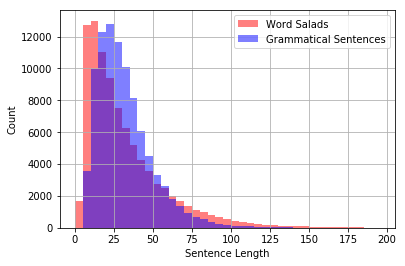

In [160]:
bins = range(0,200,5)

import matplotlib.pyplot as plt
lengths_ws = [len(ws) for ws in resp]
lengths_g = [len(g) for g in preprocessed_sentences]

plt.hist(lengths_ws, bins, alpha=0.5, label='Word Salads',facecolor="r")
plt.hist(lengths_g, bins, alpha=0.5, label='Grammatical Sentences',facecolor="b")
plt.legend(loc='upper right')

plt.xlabel('Sentence Length')
plt.ylabel('Count')
#plt.title('Sequence lengths for trigram word salads and corpus sentences')

plt.grid(True)
plt.show()

In [167]:
generateWordSalad(n_gramFreqs,3)

['por',
 'nuestra',
 'parte',
 'y',
 'hasta',
 'ahora',
 'con',
 'toda',
 'claridad',
 'estos',
 'últimos',
 'años',
 ',',
 'la',
 'representación',
 'ante',
 'los',
 'tribunales',
 ',',
 'el',
 'gobierno',
 'español',
 ',',
 'ese',
 'derroche',
 'de',
 'gasolina',
 'y',
 'del',
 'mercado',
 'único',
 'europeo',
 "''",
 ',',
 'según',
 'las',
 'cuales',
 'implican',
 'directamente',
 'cuestiones',
 'normativas',
 'respecto',
 'de',
 'cualquier',
 'tipo',
 'de',
 'comportamiento',
 'intencionales',
 ',',
 'reviste',
 'tanta',
 'importancia',
 ',',
 'tengo',
 'que',
 'decir',
 ',',
 'un',
 'proyecto',
 'mundial',
 ',',
 'en',
 'la',
 'carta',
 'social',
 '.',
 '<eos>']

In [126]:
corpus_fn

'/Users/pablo/Dropbox/workspace/darth_linguo/Data/euro_hundo/euro_hundo-pretrain'

In [162]:
10//3

3